In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [52]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [55]:
# create inspector and connect it to the engine
from sqlalchemy import inspect
inspector = inspect(engine) 

In [56]:
# Inspect the name of the tables within the database
inspector.get_table_names()

['measurement', 'station']

In [57]:
# Check table "Measurement"
columns = inspector.get_columns('measurement')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [58]:
# Check table "Station"
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [59]:
# Create a new AutomapBase class using automap_base()
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [60]:
# View the classes that the automap found
Base.classes.keys()


['measurement', 'station']

In [61]:
# Save references to each table
#Mapping measurement class
Measurement = Base.classes.measurement
# Mapping station class
Station = Base.classes.station

In [62]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


In [63]:
# Use the session to query Measurement table and display first 10 rows
session.flush()
for row in session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).limit(10).all():
    print(row)


(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)
(10, 'USC00519397', '2010-01-11', 0.01, 64.0)


In [64]:
# Use the session to query Station table and display first 10 rows
session.flush()
for row in session.query(Station.id, Station.station, Station.latitude, Station.longitude, Station.elevation).limit(10).all():
    print(row)



(1, 'USC00519397', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 21.3331, -157.8025, 152.4)


# Exploratory Climate Analysis

In [65]:
# Count the total dates in the table
total_dates = session.query(func.count(Measurement.date)).first()
# Find the start date
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
# Find the end date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Print dates
print('\033[1m' + "There are {} dates, earliest date: {} and latest date: {}".format(total_dates[0],earliest_date[0], latest_date[0])+'\033[0m')


There are 19550 dates, earliest date: 2010-01-01 and latest date: 2017-08-23


In [66]:
# Find date 12 months before the latest date
from datetime import timedelta
query_date = dt.date(2017, 8, 23)  -  dt.timedelta(days=365)
print('\033[1m'+"Date one year ago: {}".format(query_date)+'\033[0m')

Date one year ago: 2016-08-23


In [67]:
# Perform a query to retrieve the data and precipitation scores
Precipitation_one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)
for row in Precipitation_one_year.limit(10).all():
    print(row)




('2016-08-23', 0.0)
('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)
('2016-08-28', 0.01)
('2016-08-29', 0.0)
('2016-08-30', 0.0)
('2016-08-31', 0.13)
('2016-09-01', 0.0)


In [68]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(Precipitation_one_year, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
df_prcp.sort_values(by="Date", ascending=False)
print('\033[1m'+"The shape of the {} dataframe is: {}".format("precipitation",df_prcp.shape)+'\033[0m')
df_prcp.head()

The shape of the precipitation dataframe is: (2230, 2)


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [69]:
# Find the missing data
missing_data = df_prcp.isnull()
for column in missing_data.columns.values.tolist():
    print('\033[1m'+"Missing Data count: {}".format(missing_data[column].value_counts())+'\033[0m')
    

Missing Data count: False    2230
Name: Date, dtype: int64
Missing Data count: False    2021
True      209
Name: Precipitation, dtype: int64


In [71]:
# Dropping missing values from the dataframe
df_prcp.dropna(how='all',inplace = True)
# Format the date 
df_prcp["Date"] = pd.to_datetime(df_prcp["Date"])
# Set the index to the date column
df_prcp.set_index("Date", inplace=True)
print('\033[1m'+"The shape of the final {} dataframe is: {}".format("precipitation", df_prcp.shape)+'\033[0m')
df_prcp.head()



The shape of the final precipitation dataframe is: (2230, 1)


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


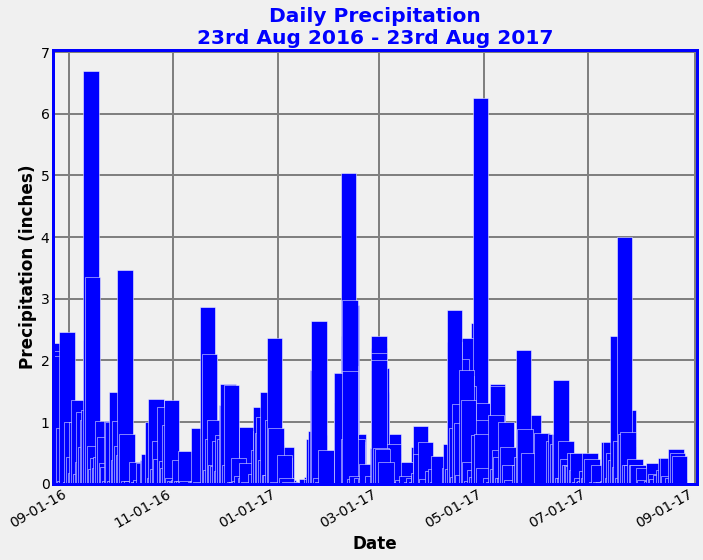

In [76]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(df_prcp.index, df_prcp["Precipitation"], color = "blue", edgecolor="white", width = 9)
ax.tick_params(axis='both', which='major', labelsize=14)
for spine in ax.spines.values():
    spine.set_edgecolor('blue')
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')
    
#Set title and labels for axes
ax.set_xlabel("Date", color = "black",fontweight = "bold")
ax.set_ylabel("Precipitation (inches)",color="black",fontweight="bold")
ax.set_title("Daily Precipitation\n23rd Aug 2016 - 23rd Aug 2017",color="blue", fontweight = "bold")

plt.grid(color="gray",linestyle = "solid",linewidth = 2)

# Date Formatting
date_form = DateFormatter("%m-%d-%y")
ax.xaxis.set_major_formatter(date_form)
x_lim_date = dt.date(2017, 8, 23) + dt.timedelta(days=10)
ax.set_xlim(query_date, x_lim_date)

# Rotate and roght align
fig.autofmt_xdate()
plt.tight_layout()
# Save the figure
plt.savefig("Images/Barchart_Daily_Prcp.png")
plt.show()







In [79]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = df_prcp.describe(include = [np.number])
# Create a dataframe
df_stats = pd.DataFrame(stats)
df_stats =df_stats.applymap("{0:.2f}".format)
df_stats.rename(columns={"Precipitation": "Last_one_year_precipitation"}, inplace=True)
print('\033[1m'+"Shape of statistics dataframe for precipitation data is:{}".format(df_stats.shape)+'\033[0m')
df_stats


Shape of statistics dataframe for precipitation data is:(8, 1)


,Last_one_year_precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [84]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct,func
# Calculate the total stations availabe in the dataset
total_stations = session.query(func.count(Station.station)).first()
distinct_stations = session.query(func.count(distinct(Station.station))).first()
# Display the count of total stations
print('\033[1m'+"There are {} stations and {} distinct stations".format(total_stations[0],distinct_stations[0])+'\033[0m')

There are 9 stations and 9 distinct stations


In [88]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

# Load the query results into a Pandas DataFrame
df_active_stations = pd.DataFrame(active_stations, columns=['Station', 'Count'])
print('\033[1m'+"The shape of {} dataframe is: {}".format("active stations", df_active_stations.shape)+'\033[0m')
df_active_stations

The shape of active stations dataframe is: (9, 2)


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [90]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
most_active_station = df_active_stations.iloc[0,0]
print('\033[1m'+"The most active station is: {}".format(most_active_station)+'\033[0m')

The most active station is: USC00519281


In [91]:
# Choose the station with the highest number of temperature observations.
Max_Temp = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            order_by(Measurement.tobs.desc()).limit(1).first()
Min_Temp = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            order_by(Measurement.tobs.asc()).limit(1).first()
print('\033[1m'+"Observed temprature from {} : Maximum {}F; Minimum. {}F".format(most_active_station,Max_Temp[0],Min_Temp[0])+'\033[0m')



Observed temprature from USC00519281 : Maximum 85.0F; Minimum. 54.0F


In [93]:
# Max, Min and Avg temp using function method
Max_Temp = session.query(func.max(Measurement.tobs).label("Max_Temp")).\
        filter(Measurement.station == most_active_station).first()
Min_Temp = session.query(func.min(Measurement.tobs).label("Min_Temp")).\
        filter(Measurement.station == most_active_station).first()
Avg_Temp = session.query(func.avg(Measurement.tobs).label("Avg_Temp")).\
        filter(Measurement.station == most_active_station).first()
data_list = [[most_active_station,Max_Temp[0],Min_Temp[0],round(Avg_Temp[0],2)]]
df_most_active_station = pd.DataFrame(data_list,columns = ["Most Active Station","Max.Temp(F)","Min.Temp(F)","avg.Temp(F)"])
df_most_active_station


,Most Active Station,Max.Temp(F),Min.Temp(F),avg.Temp(F)
0,USC00519281,85.0,54.0,71.66


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
